In [1]:
import numpy as np
import pandas as pd
import seaborn as sea 
import matplotlib.pyplot as plt

In [2]:
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
sea.set_style("whitegrid")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
import os
import time
import copy

import meth_model_utils as u
import meth_model_classes as c

import torch
import torch.nn as nn
from torchvision import utils
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [6]:
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cuda')

In [8]:
# https://pytorch.org/docs/stable/notes/randomness.html
seed = u.get_seed()
print('Seed = ', seed)
u.set_all_seeds(seed)

Seed =  324


---
---
---

In [9]:
PATH = "D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/"

In [10]:
df_luad = pd.read_csv(PATH+"meth_luad.csv", index_col=0)
df_lusu = pd.read_csv(PATH+"meth_lusu.csv", index_col=0)
df_lusu.drop(index=['MBD3L2'], axis=0, inplace=True)
df_final = u.meth_data_preprocess(df_luad, df_lusu)

In [11]:
df_final = df_final.sample(frac=1, random_state=seed).reset_index(drop=True)
labels = list(df_final['label'])
df_final.drop(columns=['label'], axis=1, inplace=True) ## drop column sample_id and label
columns = list(df_final.columns)

In [12]:
xtrain = df_final.to_numpy()
ytrain = labels

---
---
---

In [13]:
u.set_all_seeds(seed)

In [14]:
input_dim = xtrain.shape[1] 
output_dim = 2048

In [15]:
only_encoder = c.METH_AutoEncoder(input_dim, output_dim).to(device)
# only_encoder.load_state_dict(torch.load(PATH+"models/LUNG_METH_Autoencoder.kd", map_location=torch.device('cpu')))
only_encoder.load_state_dict(torch.load(PATH+"models/LUNG_METH_Autoencoder.kd"))
only_encoder = nn.Sequential(*list(only_encoder.children())[:-1])

In [16]:
classifier = c.METH_Classifier(only_encoder, output_dim).to(device)
# classifier.load_state_dict(torch.load(PATH+"models/LUNG_METH_Classifier.kd", map_location=torch.device('cpu')))
classifier.load_state_dict(torch.load(PATH+"models/LUNG_METH_Classifier.kd"))
del only_encoder

---
---
---

In [17]:
from captum.attr import IntegratedGradients, GradientShap, DeepLift

In [18]:
"""
In this method, we will select  top 150 genes that are highly correlated, positive as well as negative.
Therefore, for each class (0, 1), we will return 300 genes in total: 150 most positively correlated, 150 most negatively correlated.
"""

def get_top_genes_from_attributions(attr1, attr0, columns):
    attr0 = torch.abs(attr1)
    attr1 = torch.abs(attr0)
    attr = torch.add(attr0, attr1)
    mean_attr = torch.mean(attr, axis=0)
    temp_df = pd.DataFrame(mean_attr.cpu().detach().numpy(), columns=['mean_score']) ## when using gpu
#     temp_df = pd.DataFrame(mean_attr, columns=['mean_score'])
    temp_df.insert(0, 'genes', columns)
#     temp_df.sort_values(by=['mean_score'], ascending=False, inplace=True)
    return temp_df ## returns the entire curated attr dataset
#     return temp_df.genes[0:300], temp_df.genes[0:500], temp_df.genes[0:1000] ## only returns genes

In [19]:
inputs = torch.from_numpy(xtrain).type(torch.FloatTensor).to(device)

In [20]:
inputs.requires_grad_()

tensor([[-0.2409, -0.1083,  0.2395,  ...,  0.0487,  0.0487, -0.3371],
        [-0.3149, -0.0382,  0.1613,  ..., -0.1330, -0.1330, -0.3876],
        [ 0.0038, -0.0716,  0.1159,  ..., -0.0513, -0.0513, -0.3075],
        ...,
        [-0.4203, -0.4794,  0.2244,  ...,  0.0016,  0.0016, -0.4379],
        [-0.4551, -0.4582,  0.1067,  ..., -0.1569, -0.1569, -0.2953],
        [-0.4541, -0.4749, -0.0786,  ...,  0.0435,  0.0435, -0.3795]],
       device='cuda:0', requires_grad=True)

In [21]:
targets = torch.from_numpy(np.array(ytrain)).type(torch.IntTensor).to(device)

In [22]:
baselines = torch.Tensor(np.zeros(xtrain.shape)).to(device)

---
---
---

# Start Interpreting

In [23]:
full_path = PATH+"project_summary_seed_wise_meth/seed="+str(seed)+"/"

In [24]:
## IntegratedGradients (baselines)

u.set_all_seeds(seed)
classifier.eval()
ig_algo = IntegratedGradients(classifier)
ig_algo_attr1, d1 = ig_algo.attribute(inputs, target=0, baselines=baselines, n_steps=5, return_convergence_delta=True)
ig_algo_attr0, d0 = ig_algo.attribute(inputs, target=1, baselines=baselines, n_steps=5, return_convergence_delta=True)
print("Delta_1, Delta_0 = {}, {}".format(torch.mean(d1), torch.mean(d0)))

Delta_1, Delta_0 = -0.023582284281848366, -0.021287477985436103


In [25]:
## run this line when only gene names needed
# ig_top_genes_300, ig_top_genes_500, ig_top_genes_1000 = get_top_genes_from_attributions(ig_algo_attr1, ig_algo_attr0, columns)

## run this line when attr dataset needed
ig_top_genes = get_top_genes_from_attributions(ig_algo_attr1, ig_algo_attr0, columns)

In [73]:
ig_top_genes[10:30]

,genes,mean_score
10,DDX55,0.000898
11,FAM81A,0.000647
12,NPHP4,0.001959
13,MRPS25,0.000432
14,MAEL,0.000419
15,PROX1,0.000867
16,ELOVL1,0.000543
17,LILRA6,0.000417
18,NR5A2,0.000243
19,CDK10,0.000733


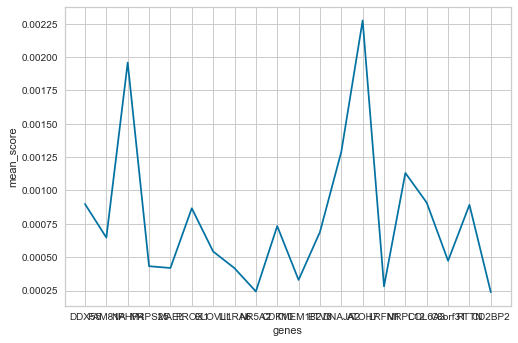

In [27]:
sea.lineplot(
    data=ig_top_genes[10:30],
    x="genes", y="mean_score",
    markers=True, dashes=True
)

In [38]:
h=list(ig_top_genes.mean_score[0:20])

In [39]:
h.sort()

In [43]:
min(h)

0.00024288423726412798

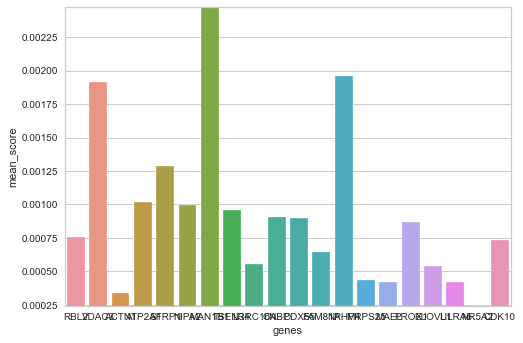

In [72]:
plt.ylim(min(h), max(h))
sea.barplot(
    data=ig_top_genes[0:20],
    x="genes",
    y='mean_score'
)

---

In [74]:
torch.cuda.empty_cache()

In [75]:
## GradientShap (baselines)

u.set_all_seeds(seed)
classifier.eval()
gradshap_algo = GradientShap(classifier)
gradshap_attr1, d1 = gradshap_algo.attribute(inputs, target=0, baselines=baselines, return_convergence_delta=True)
gradshap_attr0, d0 = gradshap_algo.attribute(inputs, target=1, baselines=baselines, return_convergence_delta=True)
print("Delta_1, Delta_0 = {}, {}".format(torch.mean(d1), torch.mean(d0)))

Delta_1, Delta_0 = -0.00249549001455307, 0.00028240898973308504


In [76]:
gradshap_top_genes = get_top_genes_from_attributions(gradshap_attr1, gradshap_attr0, columns)

In [77]:
gradshap_top_genes[50:70]

,genes,mean_score
50,MEOX2,0.000332
51,CKLF,0.001882
52,TRANK1,0.001522
53,ZFP36,0.000703
54,SLC2A9,0.000207
55,MXRA7,0.000699
56,LOXL4,0.000394
57,P2RX6P,0.001064
58,SFRS7,0.000388
59,CSMD2,0.000996


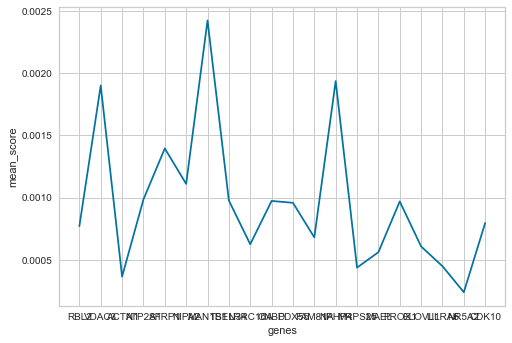

In [78]:
sea.lineplot(
    data=gradshap_top_genes[0:20],
    x="genes", y="mean_score",
    markers=True, dashes=True
)

---

In [79]:
torch.cuda.empty_cache()

In [80]:
## DeepLift (baselines)

u.set_all_seeds(seed)
classifier.eval()
deeplift_algo = DeepLift(classifier)
deeplift_attr1, d1 = deeplift_algo.attribute(inputs, target=0, baselines=baselines, return_convergence_delta=True)
deeplift_attr0, d0 = deeplift_algo.attribute(inputs, target=1, baselines=baselines, return_convergence_delta=True)
print("Delta_1, Delta_0 = {}, {}".format(torch.mean(d1), torch.mean(d0)))

Delta_1, Delta_0 = -1.6634455590747166e-08, 5.82571502150131e-08


In [81]:
deeplift_top_genes = get_top_genes_from_attributions(deeplift_attr1, deeplift_attr0, columns)

In [83]:
deeplift_top_genes[0:20]

,genes,mean_score
0,RBL2,0.000930
1,VDAC3,0.001256
2,ACTN1,0.000309
3,ATP2A1,0.001275
4,SFRP1,0.001120
5,NIPA2,0.001234
6,MAN1B1,0.002055
7,TSEN34,0.000851
8,LRRC16A,0.001038
9,CNBP,0.000765


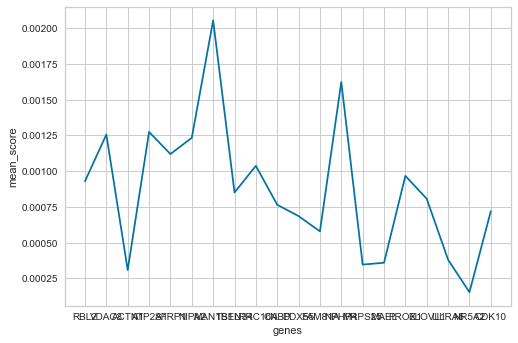

In [82]:
sea.lineplot(
    data=deeplift_top_genes[0:20],
    x="genes", y="mean_score",
    markers=True, dashes=True
)

In [ ]:
# visualize_importances(full_path, 'LUAD_DL', columns, torch.mean(deeplift_attr1, axis=0), title="Sample representation of Feature Importances computed by DeepLIFT on LUAD set") ## LUAD genes visualisation
# visualize_importances(full_path, 'LUSU_DL', columns, torch.mean(deeplift_attr0, axis=0), title="Sample representation of Feature Importances computed by DeepLIFT on LUSC set") ## LUSU genes visualisation

---
---
---

In [ ]:
from venn import venn

In [ ]:
genes_dict = {
    
    'IntegratedGrad':set(ig_top_genes_300),
    'GradShap': set(gradshap_top_genes_300),
    'DeepLift': set(deeplift_top_genes_300),
}
venn(genes_dict, cmap='prism', hint_hidden=False, figsize=(11,11), legend_loc="upper left")

plt.title("Intersection of genes using IntegratedGradients, GradientSHAP and DeepLIFT")
plt.savefig(PATH+"project_summary_seed_wise_meth/seed="+str(seed)+"/genes_venn_300", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
genes_dict = {
    
    'IntegratedGrad':set(ig_top_genes_500),
    'GradShap': set(gradshap_top_genes_500),
    'DeepLift': set(deeplift_top_genes_500),
}
venn(genes_dict, cmap='prism', hint_hidden=False, figsize=(11,11), legend_loc="upper left")

plt.title("Intersection of genes using IntegratedGradients, GradientSHAP and DeepLIFT")
plt.savefig(PATH+"project_summary_seed_wise_meth/seed="+str(seed)+"/genes_venn_500", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
genes_dict = {
    
    'IntegratedGrad':set(ig_top_genes_1000),
    'GradShap': set(gradshap_top_genes_1000),
    'DeepLift': set(deeplift_top_genes_1000),
}
venn(genes_dict, cmap='prism', hint_hidden=False, figsize=(11,11), legend_loc="upper left")

plt.title("Intersection of genes using IntegratedGradients, GradientSHAP and DeepLIFT")
plt.savefig(PATH+"project_summary_seed_wise_meth/seed="+str(seed)+"/genes_venn_1000", dpi=300, bbox_inches='tight')
plt.show()

---
---
---

In [ ]:
## write common genes to separate files

common_genes_300 =  set(deeplift_top_genes_300) & set(ig_top_genes_300) & set(gradshap_top_genes_300)
common_genes_500 =  set(deeplift_top_genes_500) & set(ig_top_genes_500) & set(gradshap_top_genes_500)
common_genes_1000 =  set(deeplift_top_genes_1000) & set(ig_top_genes_1000) & set(gradshap_top_genes_1000)

In [ ]:
u.write_seed_genes(PATH, seed, common_genes_300, 300)
u.write_seed_genes(PATH, seed, common_genes_500, 500)
u.write_seed_genes(PATH, seed, common_genes_1000, 1000)

In [ ]:
from scipy.io.wavfile import read

fs, data = read('alert.wav', mmap=True)  # fs - sampling frequency
data = data.reshape(-1, 1)
import sounddevice as sd
sd.play(data, 44100)

---
---
---

# LEVEL 3 complete !!!